In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [69]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 2: # 6:3:1
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]
  elif choose == 3: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)
 
  return train_data, test_data, val_data
  

In [70]:
df = pd.read_csv('/content/drive/MyDrive/IS403.N22/Project/dataset/TSLA_Stock.csv', parse_dates=['Date'], index_col='Date')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_data, test_data, val_data = split_data(scaled_data , 1)

Train:  934
Test:  267
Val:  134


In [71]:
n_steps = 10
n_features = 1

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Tạo input sequences cho training, validation, và testing
X_train, y_train = create_sequences(train_data, n_steps)
X_val, y_val = create_sequences(val_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

In [72]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#### CNN

In [73]:
def cnn():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(1))

  return model

In [74]:
def tcn():
  model = Sequential()
  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='causal', input_shape=(n_steps, n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=2))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=4))
  model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', dilation_rate=8))
  model.add(Flatten())
  model.add(Dense(1))

  return model

In [75]:
model = tcn()

In [76]:
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))#, metrics=[MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
29/29 [==============================] - 3s 30ms/step - loss: 0.0176 - val_loss: 0.0179
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 3/100
29/29 [==============================] - 1s 17ms/step - loss: 7.1496e-04 - val_loss: 0.0055
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 7.8285e-04 - val_loss: 0.0075
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 7.1467e-04 - val_loss: 0.0053
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 6.0288e-04 - val_loss: 0.0062
Epoch 7/100
29/29 [==============================] - 0s 11ms/step - loss: 6.0220e-04 - val_loss: 0.0050
Epoch 8/100
29/29 [==============================] - 0s 11ms/step - loss: 5.3925e-04 - val_loss: 0.0050
Epoch 9/100
29/29 [==============================] - 0s 10ms/step - loss: 6.0837e-04 - val_loss: 0.0045
Epoch 10/100
29/29 [==============================] - 0s 12ms/step - los

In [77]:
# evaluate trên tập test
loss_test = model.evaluate(X_test, y_test, verbose=0)
print("loss_test: ", loss_test)

# evaluate trên tập val
loss_val = model.evaluate(X_val, y_val, verbose=0)
print("loss_val: ", loss_val)

loss_test:  0.0012458357959985733
loss_val:  0.000359561265213415


In [78]:
def rmse_mape(true, predict):
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return rmse, mape

In [79]:
rmse_test, mape_test = rmse_mape(scaler.inverse_transform(y_test), scaler.inverse_transform(model.predict(X_test)))
rmse_val, mape_val = rmse_mape(scaler.inverse_transform(y_val), scaler.inverse_transform(model.predict(X_val)))

print('Test of rmse: ', rmse_test)
print('Test of mape: ', mape_test)

print('Validation of rmse: ', rmse_val)
print('Validation of mape: ', mape_val)

4/4 [==============================] - 0s 4ms/step
Test of rmse:  14.04938229249121
Test of mape:  0.03628756846960865
Validation of rmse:  7.547676173812838
Validation of mape:  0.03507855246703609


In [80]:
def predict_future(number_days):
  last_sequence = X_val[-1:]
  predicted_values = []
  for _ in range(number_days):
    next_value = model.predict(last_sequence)
    predicted_values.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)
  predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  return predicted_values

1/1 [==============================] - 0s 39ms/step


<ipython-input-81-b5ae301b27d1>:30: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')


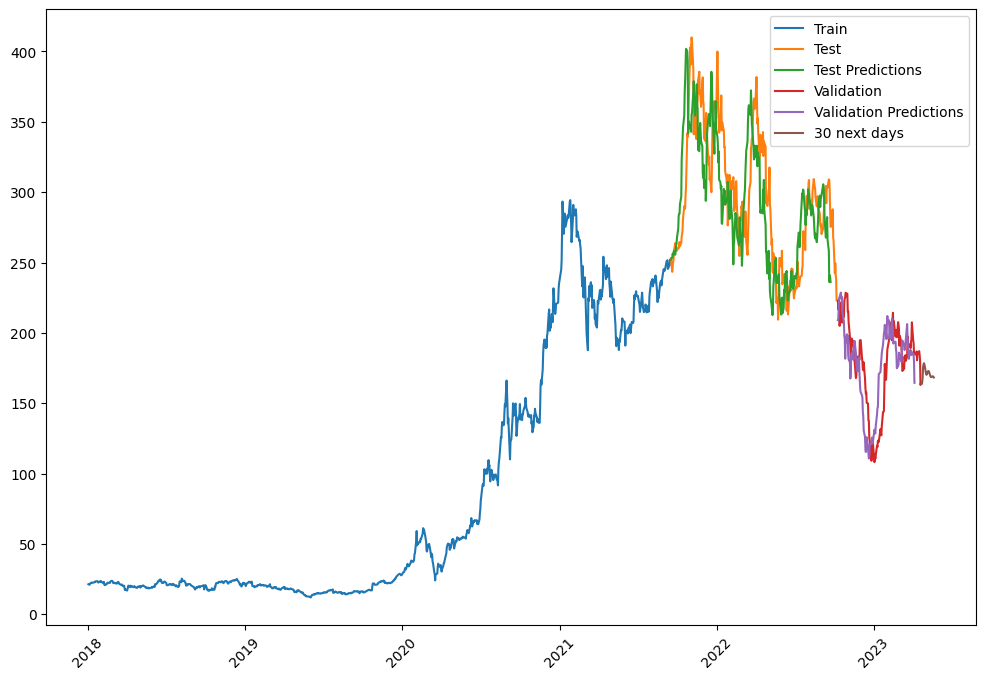

In [81]:
number_days = 30

train_actual = scaler.inverse_transform(train_data.reshape(-1, 1))
val_actual = scaler.inverse_transform(val_data.reshape(-1, 1))
test_actual = scaler.inverse_transform(test_data.reshape(-1, 1))

# Inverse scale the training, validation, and testing predictions
val_predictions = scaler.inverse_transform(model.predict(X_val))
test_predictions = scaler.inverse_transform(model.predict(X_test))


# Create an array of dates for the time steps
dates = df.index

# Plot the training data
plt.figure(figsize=(12, 8))
plt.plot(dates[:len(train_actual)], train_actual, label='Train')

# Plot the validation data
test_offset = len(train_actual)
plt.plot(dates[test_offset:test_offset + len(test_actual)], test_actual, label='Test')
plt.plot(dates[test_offset:test_offset + len(test_predictions)], test_predictions, label='Test Predictions')

# Plot the testing data
val_offset = test_offset + len(test_actual)
plt.plot(dates[val_offset:val_offset + len(val_actual)], val_actual, label='Validation')
plt.plot(dates[val_offset:val_offset + len(val_predictions)], val_predictions, label='Validation Predictions')

predicted_values = predict_future(number_days)
next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')
plt.plot(next30days_offset, predicted_values, label='30 next days')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

plt.legend()
plt.show()
